In [7]:
# --- JUPYTER NOTEBOOK CELL: IMPORTS & SETUP ---
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Helper function to display images in the notebook
def show_images(original, processed, title_processed):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap="gray", vmin=0, vmax=255)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(processed, cmap="gray", vmin=0, vmax=255)
    plt.title(title_processed)
    plt.axis("off")

    plt.show()

img = cv2.imread("img/cameraman2.png", cv2.IMREAD_GRAYSCALE)

### Exercice 1: Seuillage combiné (Combined Thresholding)
Goal: Apply a low threshold (tb) and a high threshold (th).
Logic: 
  - x <= tb: Vmin (0)
  - tb < x <= th: x (unchanged)
  - x > th: Vmax (255)

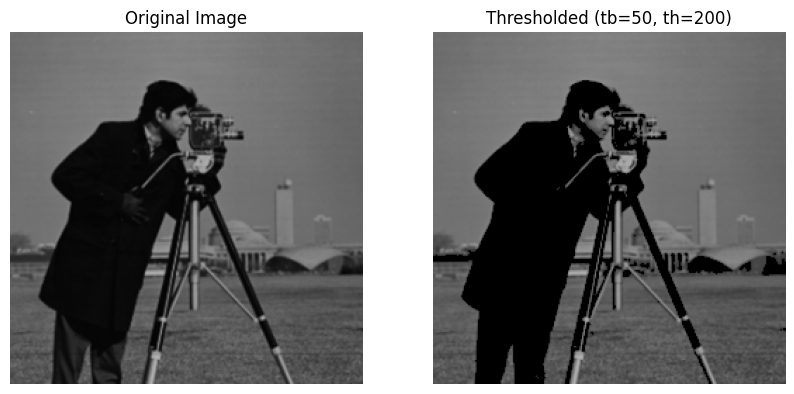

In [8]:
def manual_threshold(image, tb, th):
    # Create a copy to avoid modifying the original
    result = image.copy()
    rows, cols = result.shape
    
    # Iterate over all pixels 
    for i in range(rows):
        for j in range(cols):
            pixel_val = result[i, j]
            if pixel_val <= tb:
                result[i, j] = 0       # Vmin
            elif pixel_val > th:
                result[i, j] = 255     # Vmax
            # else: keep pixel_val
            
    return result

# Test
tb, th = 50, 200
img_thresh = manual_threshold(img, tb, th)
show_images(img, img_thresh, f"Thresholded (tb={tb}, th={th})")




### Exercice 2: Normalisation d'histogramme (Histogram Normalization)
- Goal: Stretch the intensity range to cover [Vmin, Vmax].
- Formula: norm(x) = (x - f_min) * (Vmax - Vmin) / (f_max - f_min) + Vmin



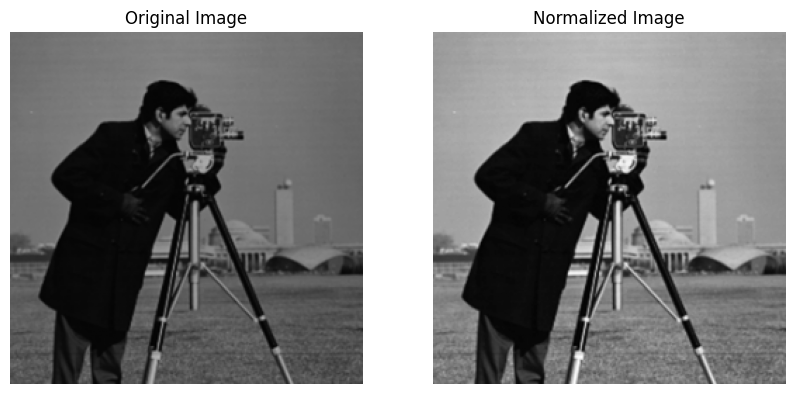

In [10]:
def manual_normalize(image):
    result = image.copy().astype(float)
    f_min = np.min(image)
    f_max = np.max(image)
    V_min, V_max = 0, 255
    
    if f_max == f_min:
        return image # Avoid division by zero
        
    # Apply affine transformation
    result = (result - f_min) * (V_max - V_min) / (f_max - f_min) + V_min
    
    return result.astype(np.uint8)

# Test
normalized_img = manual_normalize(img)
show_images(img, normalized_img, "Normalized Image")

### Exercice 3: Quantification (Quantization)
- Goal: Reduce the number of gray levels to k values.
- Logic: Divide [0, 255] into k intervals of uniform length.


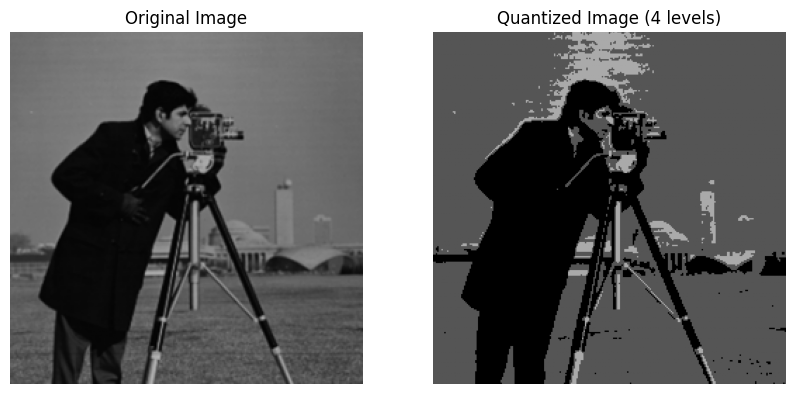

In [11]:
def manual_quantize(image, k):
    result = image.copy()
    rows, cols = result.shape
    
    # Size of each interval
    interval_size = 256 / k
    
    for i in range(rows):
        for j in range(cols):
            val = result[i, j]
            # Find interval index
            interval_index = int(val / interval_size)
            # Map back to value (e.g., start of interval or center)
            new_val = interval_index * (255 / (k - 1)) 
            result[i, j] = int(new_val)
            
    return result

# Test with k=4 levels
img_quant = manual_quantize(img, 4)
show_images(img, img_quant, "Quantized Image (4 levels)")



### Exercice 4: Egalisation d'histogramme (Histogram Equalization)
- Goal: Flatten the histogram using the cumulative distribution function (CDF).
- Formula: eq(v) = ((Vmax - Vmin) / N) * C_f(v) + Vmin


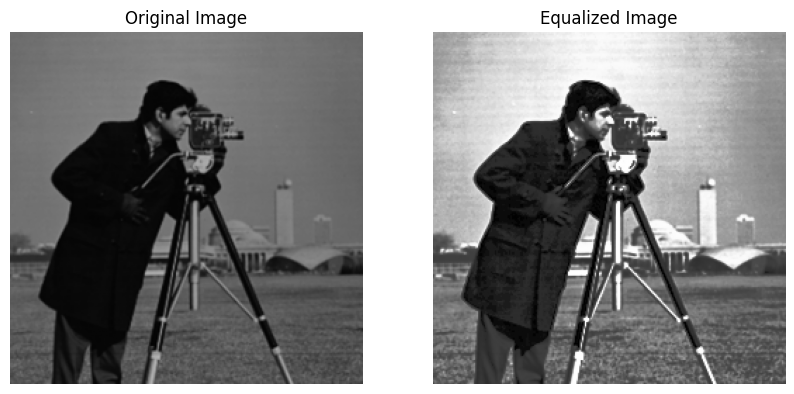

In [12]:
def manual_equalize(image):
    # 1. Compute Histogram
    hist = np.zeros(256, dtype=int)
    rows, cols = image.shape
    N = rows * cols
    
    for i in range(rows):
        for j in range(cols):
            hist[image[i, j]] += 1
            
    # 2. Compute Cumulative Histogram (C_f)
    cum_hist = np.zeros(256, dtype=int)
    current_sum = 0
    for v in range(256):
        current_sum += hist[v]
        cum_hist[v] = current_sum
        
    # 3. Apply Transformation map
    # eq(v) formula with Vmin=0, Vmax=255
    mapping = np.zeros(256, dtype=np.uint8)
    for v in range(256):
        mapping[v] = int((255.0 / N) * cum_hist[v])
        
    # 4. Generate result image
    result = image.copy()
    for i in range(rows):
        for j in range(cols):
            result[i, j] = mapping[image[i, j]]
            
    return result

# Test
img_eq = manual_equalize(img)
show_images(img, img_eq, "Equalized Image")



### Exercice 5: Méthode d'Otsu (Otsu's Thresholding)
- Goal: Find optimal threshold minimizing intra-class variance (or max inter-class).



Optimal Otsu Threshold found: 61


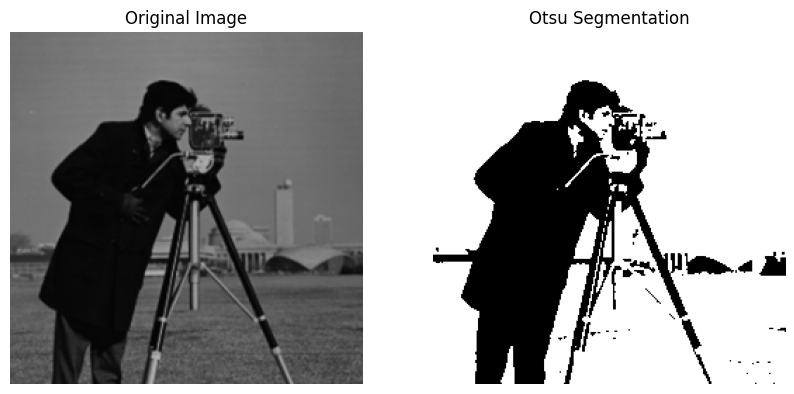

In [14]:
def manual_otsu(image):
    # Compute histogram
    hist = np.zeros(256, dtype=int)
    rows, cols = image.shape
    N = rows * cols
    for i in range(rows):
        for j in range(cols):
            hist[image[i, j]] += 1
            
    best_thresh = 0
    max_variance = 0
    
  
    sum_total = sum(i * hist[i] for i in range(256))
    
    sum_b = 0
    w_b = 0 # Weight background
    w_f = 0 # Weight foreground
    
    for t in range(256):
        w_b += hist[t]
        if w_b == 0: continue
        
        w_f = N - w_b
        if w_f == 0: break
        
        sum_b += t * hist[t]
        
        m_b = sum_b / w_b  # Mean background
        m_f = (sum_total - sum_b) / w_f # Mean foreground
        
        # Inter-class variance
        var_between = w_b * w_f * (m_b - m_f) ** 2
        
        if var_between > max_variance:
            max_variance = var_between
            best_thresh = t
            
    print(f"Optimal Otsu Threshold found: {best_thresh}")
    
    # Apply the threshold (using  function from Ex 1)
    # For binarization, typical usage is: if x > thresh then 255 else 0.
    # So use tb=thresh, th=thresh in  combined function implies 
    # values between are kept, which isn't binary. 
    # Standard binary threshold: x <= t -> 0, x > t -> 255.
    # We can adapt manual_threshold by setting tb=best_thresh and th=best_thresh
    # But strictly, binary threshold is:
    result = image.copy()
    for i in range(rows):
        for j in range(cols):
            result[i, j] = 255 if image[i, j] > best_thresh else 0
            
    return result

# Test
img_otsu = manual_otsu(img)
show_images(img, img_otsu, "Otsu Segmentation")